# Basics on integrating ODE, adjoint method, etc.

In [16]:
import torch

### 1- Solving an ODE

Assume the following ODE (Lorenz attractor)

\begin{align}
    \begin{matrix}
        \frac{dx}{dt} \\ \frac{dy}{dt} \\ \frac{dz}{dt}
    \end{matrix} &=
    \begin{matrix}
        \sigma \left( y(t) - x(t) \right) \\
        \rho x(t) - y(t) - x(t)z(t) \\
        x(t)y(t) - \beta z(t)
    \end{matrix}
\end{align}

with $\sigma, \rho, \beta > 0$.

In [ ]:
sigma = 10
beta = 8/3
rho = 28

def func(t, vec):
    # signature of func must be func(t, y)
    x, y, z = vec
    x_dot = sigma * (y - x)
    y_dot = x * (rho - z) - y
    z_dot = x * y - beta * z
    return x_dot, y_dot, z_dot

X0 = [1.0, 1.0, 1.0]

t_start = 0.0
t_end = 40.0
t_span = (t_start, t_end)

In [9]:
from scipy.integrate import solve_ivp
import numpy as np

t_eval = np.linspace(t_start, t_end, 10000)

sol = solve_ivp(func, t_span, X0, t_eval=t_eval)

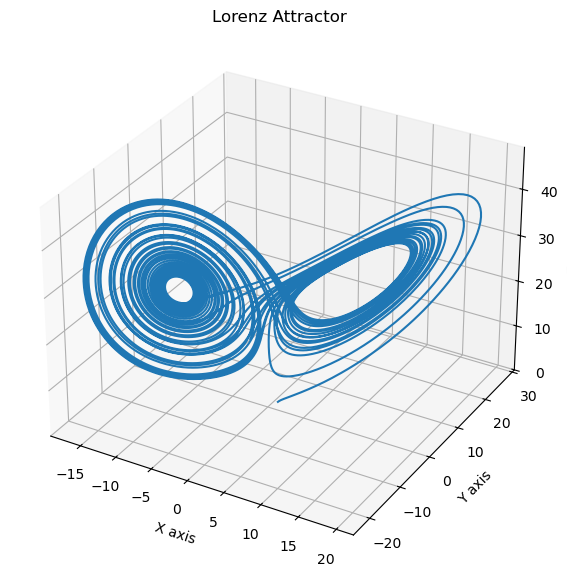

In [12]:
# plot results in 3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 7))
ax.plot(sol.y[0], sol.y[1], sol.y[2])
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")
ax.set_title("Lorenz Attractor")
plt.show()

### 2- Model with parameters

In [14]:
def f_theta(t, u, theta):
    # theta = (sigma, beta, rho) tuple de paramètres
    sigma, beta, rho = theta
    x, y, z = u
    x_dot = sigma * (y - x)
    y_dot = x * (rho - z) - y
    z_dot = x * y - beta * z
    return [x_dot, y_dot, z_dot]

Testing the pipeline

In [19]:
# 1- Solve the ODE with some parameters
theta_tensor = torch.tensor([0.5,0.5,0.5], requires_grad=True)
theta = theta_tensor.detach().numpy()

model_sol = solve_ivp(lambda t, y: f_theta(t, y, theta), t_span, X0, t_eval=t_eval)

print(f"Shape de l'output du modèle: {model_sol.y.shape}")

Shape de l'output du modèle: (3, 10000)


### 3- Form adjoint ODE:

\begin{align}
    \frac{d\lambda}{dt} &= - \left( \frac{\partial f}{\partial u} \right)^T \lambda + \left( \frac{\partial g}{\partial u} \right)^T
\end{align}